In [1]:
import os
import copy
import functools
from collections import defaultdict

import lmfit
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import linregress
from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters 

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity
from sivqed.models.fitter import cavity_ref_model, single_siv_ref_model, mcmc
from sivqed.models.fitter import single_siv_ref, two_siv_ref, cavity_ref, three_siv_ref
from sivqed.models.diffusion import diffused_siv_peaks, plot_diffused_contrasts

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
siv_path = "../data/20210813_diosBL_bb02_SiV_backtunes/"

siv_folders = ["406_450/", "406_490/", "406_530/", "406_570/", "406_610/"]

# Extract the fwd avg files from each folder
siv_files = [ [file for file in os.listdir(siv_path + folder) 
                if "fwd_avg" in file and file.endswith(".txt")] 
             for folder in siv_folders
           ]

# Plot data

## Plot SiV Data

Loaded file ../data/20210813_diosBL_bb02_SiV_backtunes/406_450/sweeper_fwd_avg_15_03_59.txt!
Loaded file ../data/20210813_diosBL_bb02_SiV_backtunes/406_450/sweeper_fwd_avg_15_25_55.txt!
Loaded file ../data/20210813_diosBL_bb02_SiV_backtunes/406_450/sweeper_fwd_avg_15_31_40.txt!
Loaded file ../data/20210813_diosBL_bb02_SiV_backtunes/406_450/sweeper_fwd_avg_15_35_54.txt!
Loaded file ../data/20210813_diosBL_bb02_SiV_backtunes/406_450/sweeper_fwd_avg_15_39_55.txt!
Loaded file ../data/20210813_diosBL_bb02_SiV_backtunes/406_450/sweeper_fwd_avg_15_44_09.txt!
Loaded file ../data/20210813_diosBL_bb02_SiV_backtunes/406_490/sweeper_fwd_avg_16_24_22.txt!
Loaded file ../data/20210813_diosBL_bb02_SiV_backtunes/406_490/sweeper_fwd_avg_16_27_19.txt!
Loaded file ../data/20210813_diosBL_bb02_SiV_backtunes/406_530/sweeper_fwd_avg_16_58_07.txt!
Loaded file ../data/20210813_diosBL_bb02_SiV_backtunes/406_530/sweeper_fwd_avg_17_00_58.txt!
Loaded file ../data/20210813_diosBL_bb02_SiV_backtunes/406_530/sweeper

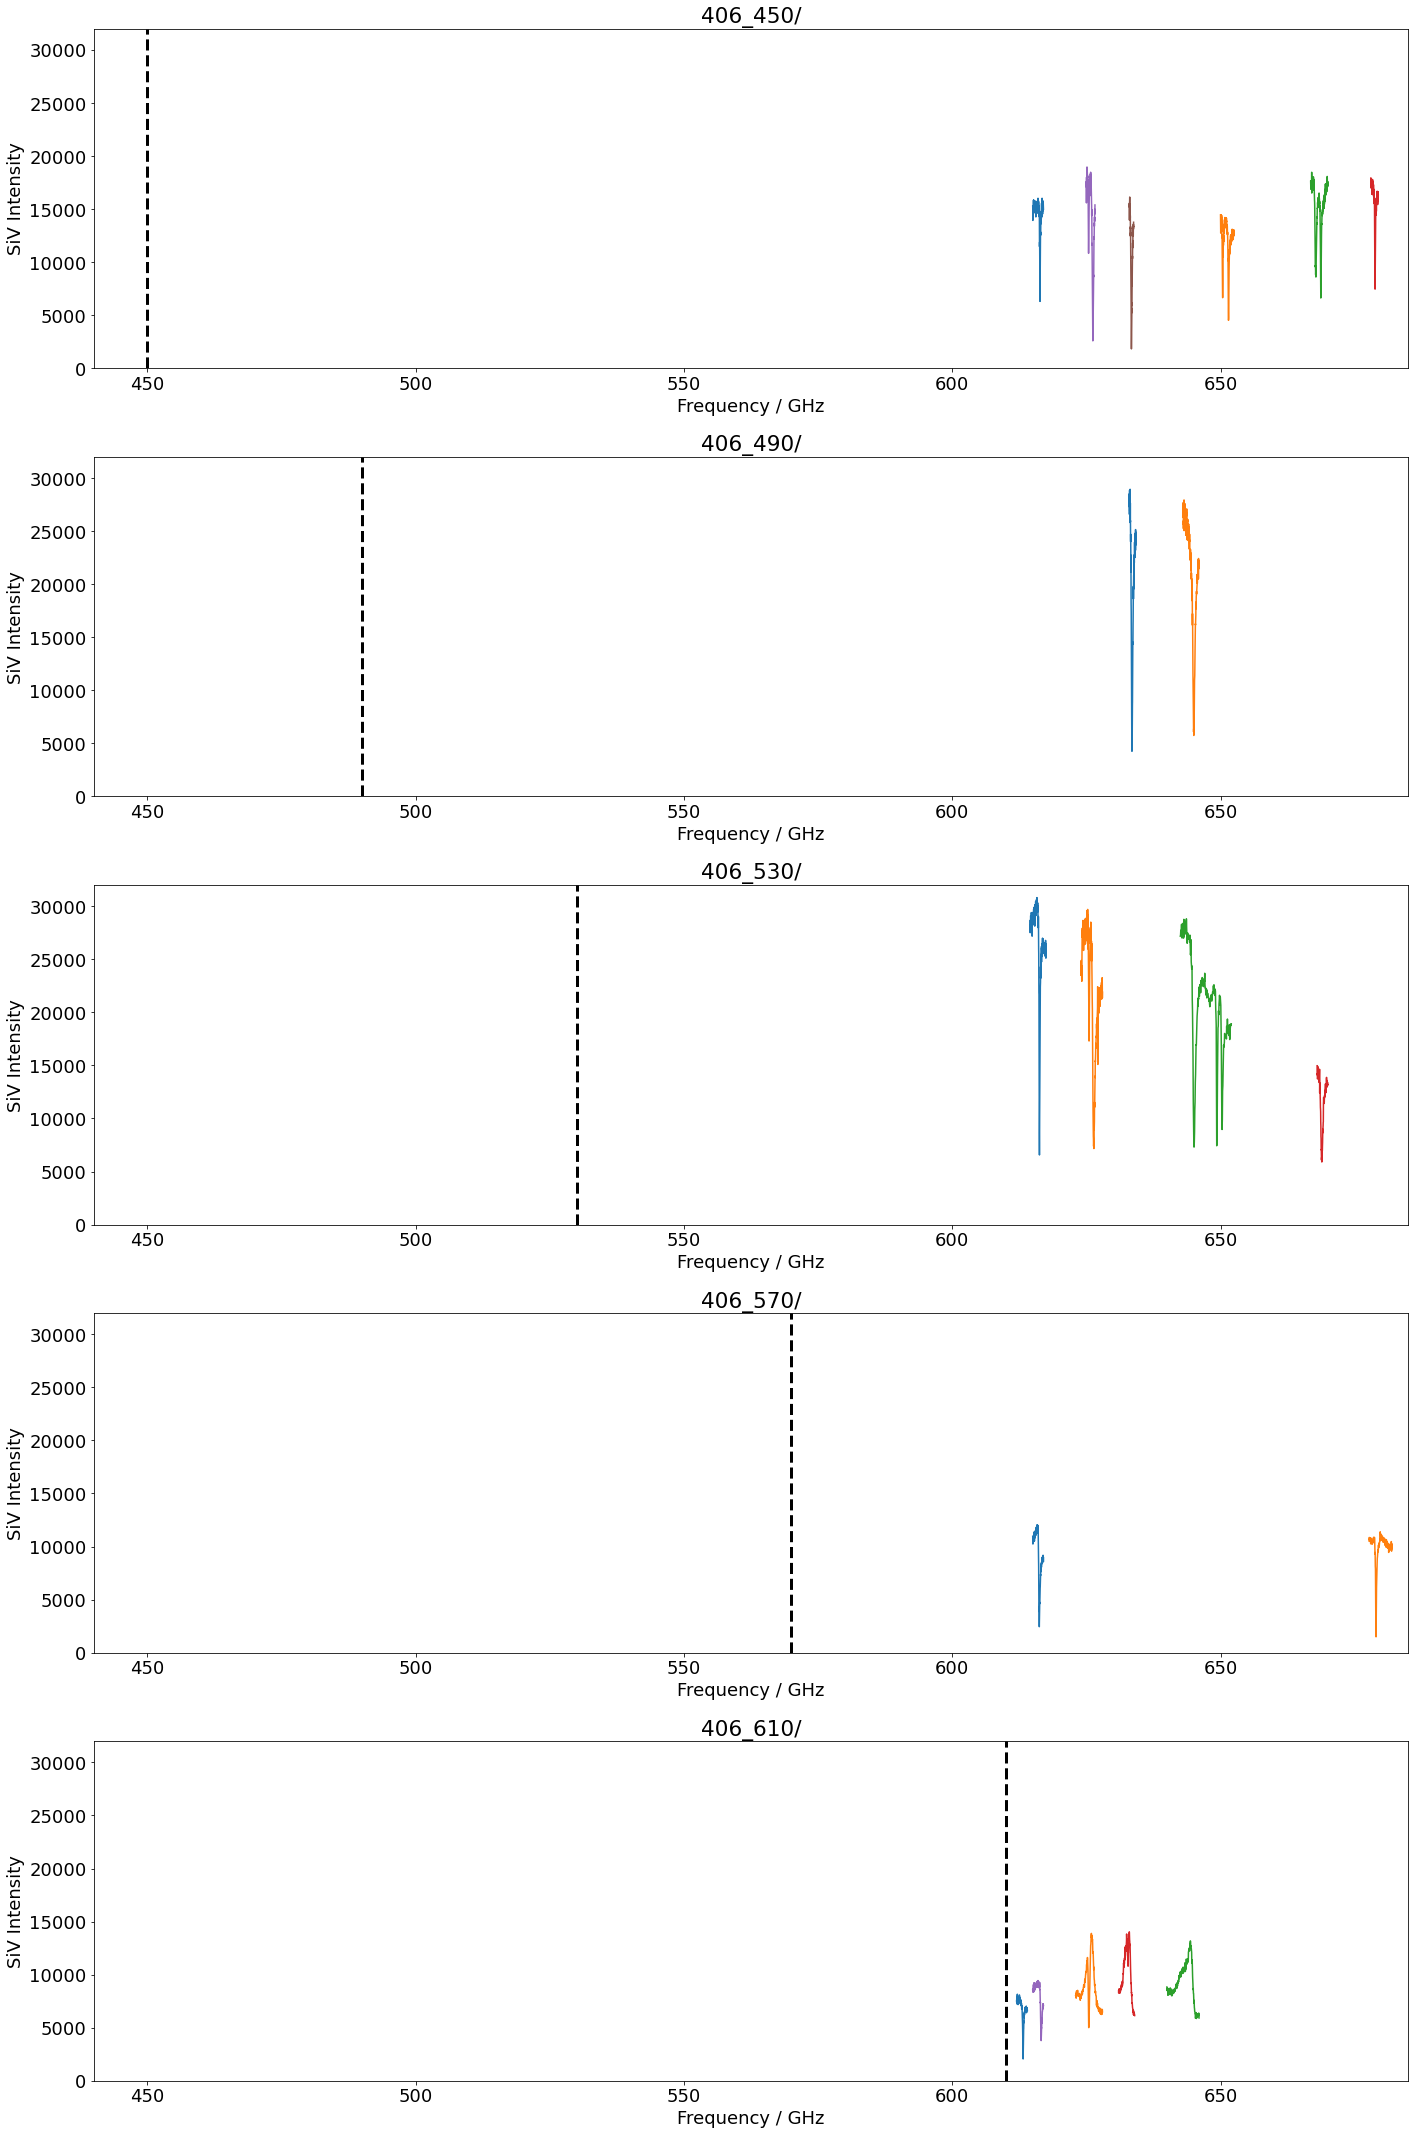

In [3]:
ncols = 1
nrows = int(np.ceil(len(siv_folders) / ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=[20, 6*nrows])
# Reshape into a 1D array of subplots easy indexing
ax = ax.flatten()

for folder_idx, folder_name in enumerate(siv_folders):
    axes = ax[folder_idx]
    cavity_freq = float(folder_name[:-1].replace("_", "."))
    cavity_freq = (cavity_freq - 406) * 1000
    
    for siv_filename in siv_files[folder_idx]:
        siv_file_path = siv_path + folder_name + siv_filename
        
        # Extract freq from the avg scan file
        siv_freqs, siv_data = np.loadtxt(siv_file_path)
        print(f"Loaded file {siv_file_path}!")

        siv_freqs = 1000 * (siv_freqs - 406) # Convert to GHz
        axes.plot(siv_freqs, siv_data)

    axes.set_xlabel("Frequency / GHz")
    axes.set_ylabel("SiV Intensity")
    axes.set_xlim(440, 685)
    axes.set_ylim(0, 32000)
    axes.axvline(x=cavity_freq, color="k", linestyle="--", linewidth=3)
    axes.set_title(folder_name)

fig.tight_layout()

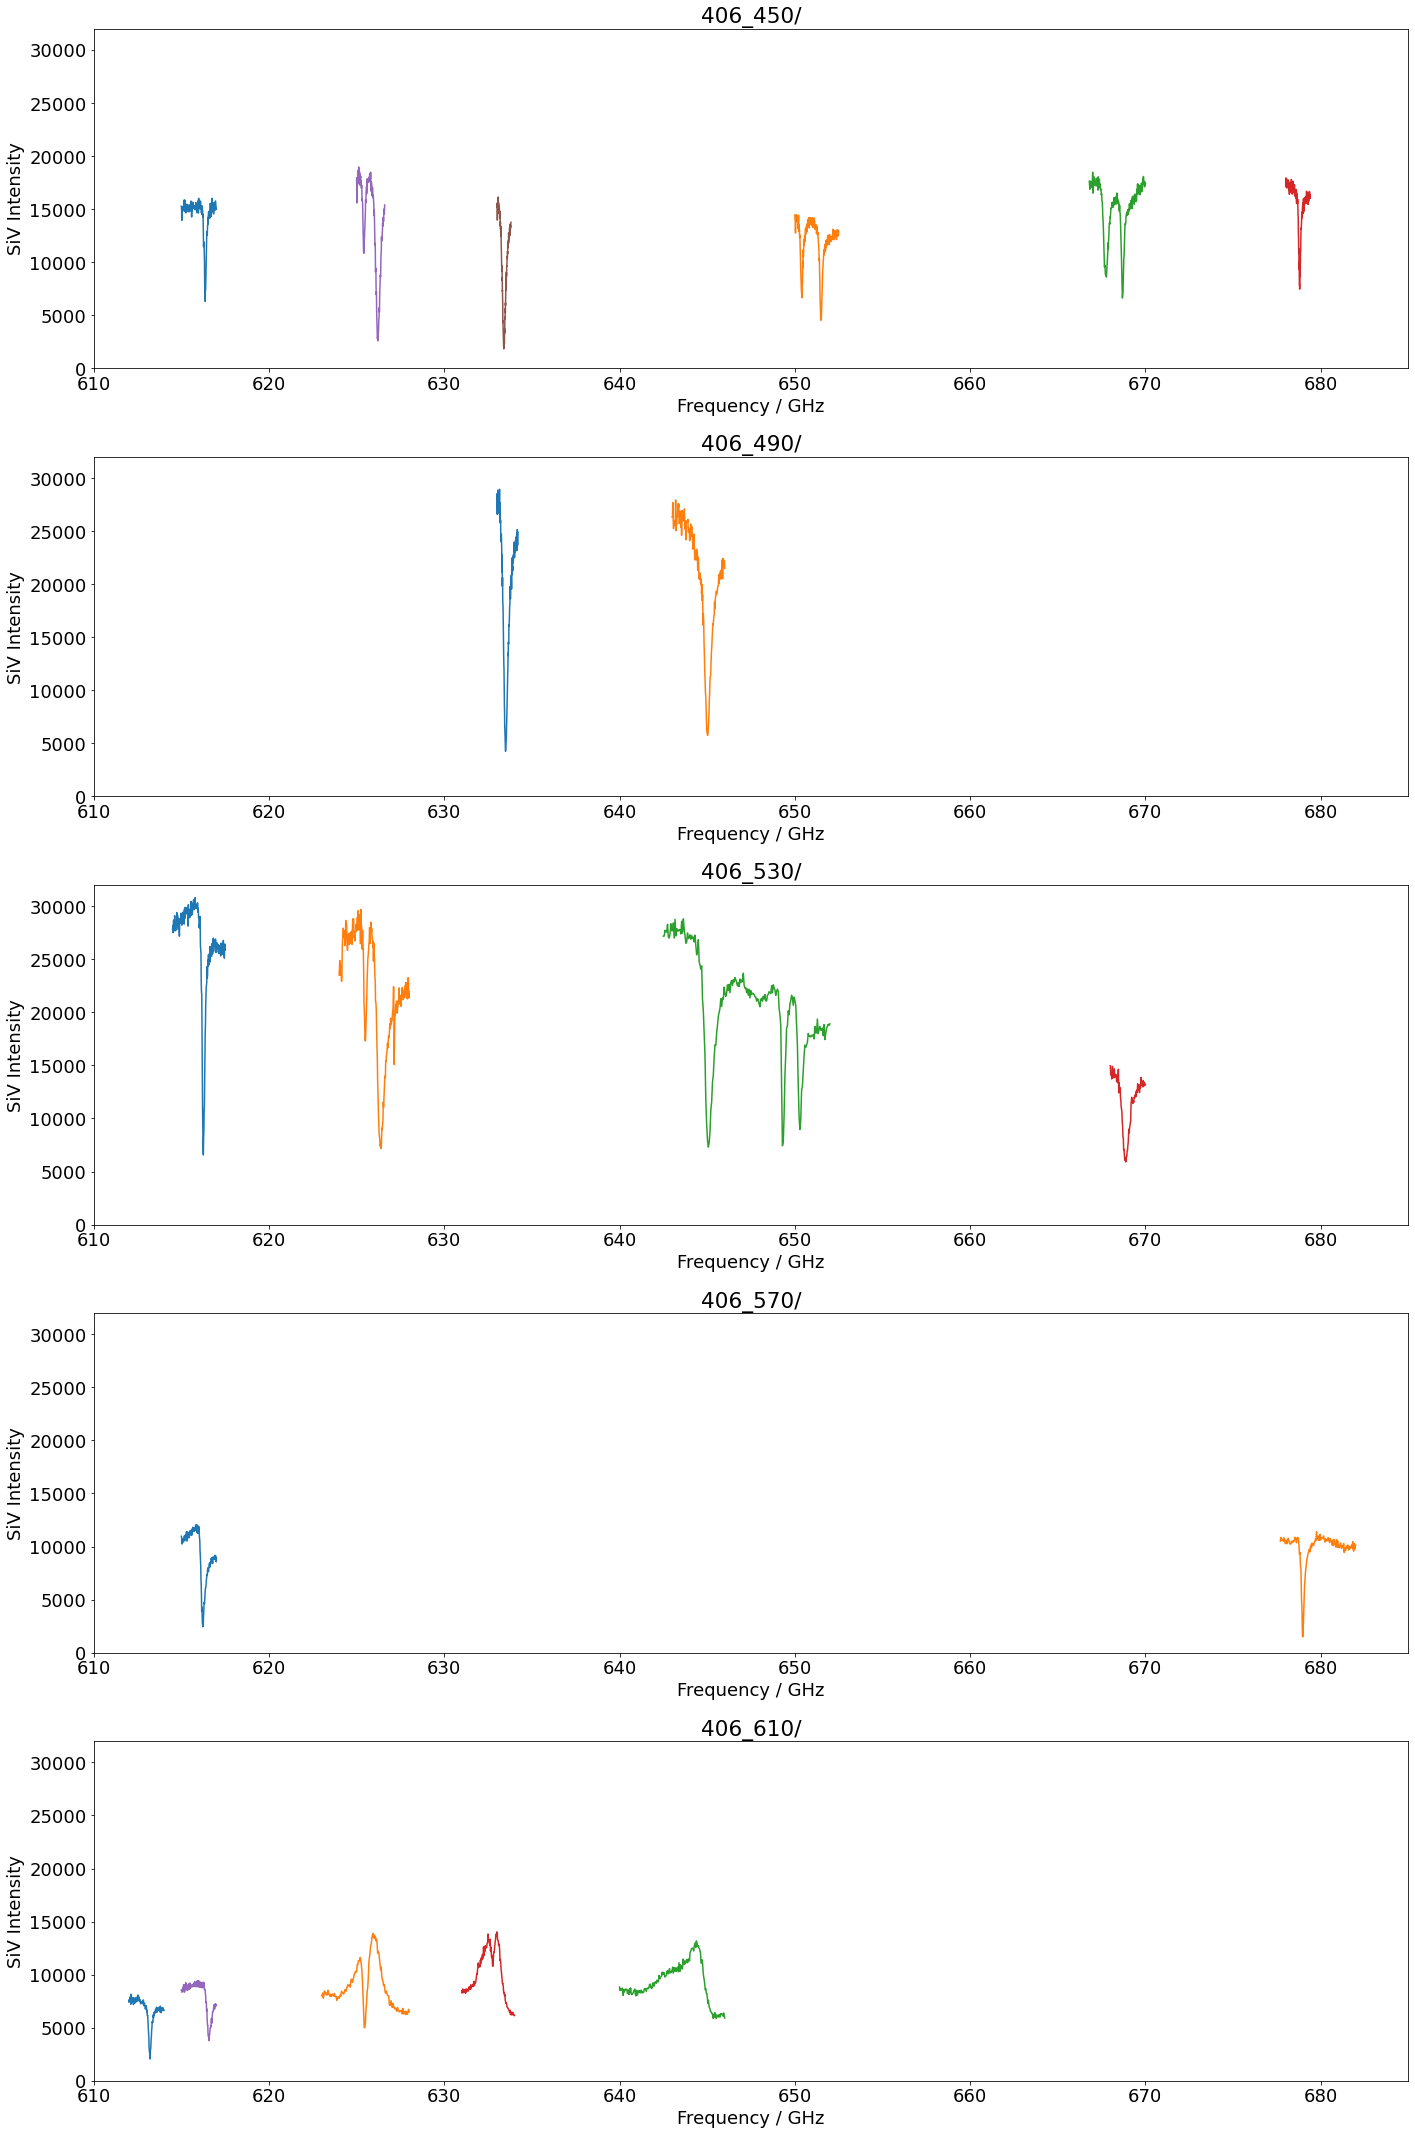

In [4]:
ncols = 1
nrows = int(np.ceil(len(siv_folders) / ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=[20, 6*nrows])
# Reshape into a 1D array of subplots easy indexing
ax = ax.flatten()

for folder_idx, folder_name in enumerate(siv_folders):
    axes = ax[folder_idx]
    cavity_freq = float(folder_name[:-1].replace("_", "."))
    cavity_freq = (cavity_freq - 406) * 1000
    
    for siv_filename in siv_files[folder_idx]:
        siv_file_path = siv_path + folder_name + siv_filename
        
        # Extract freq from the avg scan file
        siv_freqs, siv_data = np.loadtxt(siv_file_path)

        siv_freqs = 1000 * (siv_freqs - 406) # Convert to GHz
        axes.plot(siv_freqs, siv_data)

    axes.set_xlabel("Frequency / GHz")
    axes.set_ylabel("SiV Intensity")
    axes.set_xlim(610, 685)
    axes.set_ylim(0, 32000)
#     axes.axvline(x=cavity_freq, color="k", linestyle="--", linewidth=3)
    axes.set_title(folder_name)

fig.tight_layout()

In [5]:
def get_val_from_model(params, scan_idx, detuning_idx, model, w):   
    w_c = params[f"w_c_det{detuning_idx}"]
    k_in = params["k_in"]
    k_tot = params["k_tot"]
    A = params["A"]
    B = params["B"]
    
    if model == single_siv_ref:
        w_up = params[f"w_up_scan{scan_idx}_det{detuning_idx}"]
        g_up = params[f"g_up_scan{scan_idx}_det{detuning_idx}"]
        gamma_up = params[f"gamma_up_scan{scan_idx}_det{detuning_idx}"]
        args = [w_up, g_up, gamma_up, w_c, k_in, k_tot, A, B]
    else:
        w_up_1 = params[f"w_up_1_scan{scan_idx}_det{detuning_idx}"]
        g_up_1 = params[f"g_up_1_scan{scan_idx}_det{detuning_idx}"]
        gamma_up_1 = params[f"gamma_up_1_scan{scan_idx}_det{detuning_idx}"]
        w_up_2 = params[f"w_up_2_scan{scan_idx}_det{detuning_idx}"]
        g_up_2 = params[f"g_up_2_scan{scan_idx}_det{detuning_idx}"]
        gamma_up_2 = params[f"gamma_up_2_scan{scan_idx}_det{detuning_idx}"]
        
        if model == two_siv_ref:
            args = [w_up_1, g_up_1, gamma_up_1, w_up_2, g_up_2, gamma_up_2, w_c, k_in, k_tot, A, B]
        elif model == three_siv_ref:
            w_up_3 = params[f"w_up_3_scan{scan_idx}_det{detuning_idx}"]
            g_up_3 = params[f"g_up_3_scan{scan_idx}_det{detuning_idx}"]
            gamma_up_3 = params[f"gamma_up_3_scan{scan_idx}_det{detuning_idx}"]
            args = [w_up_1, g_up_1, gamma_up_1, w_up_2, g_up_2, gamma_up_2, 
                    w_up_3, g_up_3, gamma_up_3, w_c, k_in, k_tot, A, B]
        else:
            raise Exception

    return model(w, *args)

def objective(params, freqs_lst_all, data_lst_all, model_list_all):
    residuals_lst = np.array([])
    
    for detuning_idx in range(len(freqs_lst_all)):
        
        freqs_lst = freqs_lst_all[detuning_idx]
        data_lst = data_lst_all[detuning_idx]
        model_list = model_list_all[detuning_idx]

        # compute residual per data set
        for scan_idx in range(len(data_lst)):
            model = model_list[scan_idx]
            freqs = freqs_lst[scan_idx]
            data = data_lst[scan_idx]

            residual = data - get_val_from_model(params, scan_idx, detuning_idx, model, freqs)
            residuals_lst = np.append(residuals_lst, residual)

    return residuals_lst

def collect_folder_data(folder_idx):

    siv_freqs_list = []
    siv_data_list = []

    folder_name = siv_folders[folder_idx]
    print(f"Fitting folder {folder_name}")

    cavity_freq = float(folder_name[:-1].replace("_", "."))
    cavity_freq = (cavity_freq - 406) * 1000

    for siv_filename in siv_files[folder_idx]:
        siv_file_path = siv_path + folder_name + siv_filename
        siv_freqs, siv_data = np.loadtxt(siv_file_path)
        siv_freqs = 1000 * (siv_freqs - 406) # Convert to GHz

        siv_freqs_list.append(siv_freqs)
        siv_data_list.append(siv_data)

    return siv_freqs_list, siv_data_list

def fit_combined_data(fit_params, objective, folder_idx_list, model_list_all, w_up_guesses_all):
            
    siv_freqs_list_all = []
    siv_data_list_all = []

    for detuning_idx, folder_idx in enumerate(folder_idx_list):
        siv_freqs_list, siv_data_list = collect_folder_data(folder_idx=folder_idx)
        siv_freqs_list_all.append(siv_freqs_list)
        siv_data_list_all.append(siv_data_list)
        
        model_list = model_list_all[detuning_idx]
        w_up_guesses = w_up_guesses_all[detuning_idx]
    
        num_scans = len(siv_data_list)
        for scan_idx in range(num_scans):
            model = model_list[scan_idx]

            if model == single_siv_ref:
                w_up_guess = w_up_guesses[scan_idx]
                fit_params.add(f"w_up_scan{scan_idx}_det{detuning_idx}", value=w_up_guess, min=w_up_guess-1, max=w_up_guess+1)
                fit_params.add(f"g_up_scan{scan_idx}_det{detuning_idx}", value=5.6, min=1, max=20)
                fit_params.add(f"gamma_up_scan{scan_idx}_det{detuning_idx}", value=0.05, vary=False)
            else:
                fit_params.add(f"g_up_1_scan{scan_idx}_det{detuning_idx}", value=5.6, min=1, max=20)
                fit_params.add(f"gamma_up_1_scan{scan_idx}_det{detuning_idx}", value=0.05, vary=False)
                fit_params.add(f"g_up_2_scan{scan_idx}_det{detuning_idx}", value=5.6, min=1, max=20)
                fit_params.add(f"gamma_up_2_scan{scan_idx}_det{detuning_idx}", value=0.05, vary=False)

                if model == two_siv_ref:
                    w_up_guess_1, w_up_guess_2 = w_up_guesses[scan_idx]
                    fit_params.add(f"w_up_1_scan{scan_idx}_det{detuning_idx}", value=w_up_guess_1, min=w_up_guess_1-1, max=w_up_guess_1+1)
                    fit_params.add(f"w_up_2_scan{scan_idx}_det{detuning_idx}", value=w_up_guess_2, min=w_up_guess_2-1, max=w_up_guess_2+1)
                elif model == three_siv_ref:
                    w_up_guess_1, w_up_guess_2, w_up_guess_3 = w_up_guesses[scan_idx]
                    fit_params.add(f"w_up_1_scan{scan_idx}_det{detuning_idx}", value=w_up_guess_1, min=w_up_guess_1-1, max=w_up_guess_1+1)
                    fit_params.add(f"w_up_2_scan{scan_idx}_det{detuning_idx}", value=w_up_guess_2, min=w_up_guess_2-1, max=w_up_guess_2+1)
                    fit_params.add(f"w_up_3_scan{scan_idx}_det{detuning_idx}", value=w_up_guess_3, min=w_up_guess_3-1, max=w_up_guess_3+1)
                    fit_params.add(f"g_up_3_scan{scan_idx}_det{detuning_idx}", value=5.6, min=1, max=20)
                    fit_params.add(f"gamma_up_3_scan{scan_idx}_det{detuning_idx}", value=0.05, vary=False)    

    out = lmfit.minimize(objective, fit_params, args=(siv_freqs_list_all, siv_data_list_all, model_list_all), method="lbfgsb")
    return out

In [40]:
fit_params = Parameters()
fit_params.add("w_c_det0", value=610, min=510, max=700)
fit_params.add("w_c_det1", value=450, min=350, max=550)
fit_params.add("w_c_det2", value=530, min=430, max=630)
fit_params.add("k_in", value=50, min=10, max=150)
fit_params.add("k_tot", value=100, min=15, max=300)
fit_params.add("A", value=25000, min=5000, max=100000)
fit_params.add("B", value=0, vary=False)

model_list_all = []
w_up_guesses_all = []
folder_idx_list = []

model_list_all.append([single_siv_ref, two_siv_ref, single_siv_ref, two_siv_ref, single_siv_ref])
w_up_guesses_all.append([613, (625, 626), 644, (632, 633), 616.5])
folder_idx_list.append(4)

model_list_all.append([single_siv_ref, two_siv_ref, two_siv_ref, single_siv_ref, two_siv_ref, single_siv_ref])
w_up_guesses_all.append([616.4, (650.5, 651.5), (667.5, 668.5), 678.8, (625.5, 626.25), 633.4])
folder_idx_list.append(0)

model_list_all.append([single_siv_ref, two_siv_ref, three_siv_ref, single_siv_ref])
w_up_guesses_all.append([616.25, (625.5, 626.25), (645, 649.5, 650.25), 669])
folder_idx_list.append(2)

In [41]:
out = fit_combined_data(fit_params, objective, folder_idx_list, model_list_all, w_up_guesses_all)
lmfit.report_fit(out)

Fitting folder 406_610/
Fitting folder 406_450/
Fitting folder 406_530/
[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 15052
    # data points      = 2515
    # variables        = 52
    chi-square         = 1.5743e+10
    reduced chi-square = 6391720.69
    Akaike info crit   = 39462.7978
    Bayesian info crit = 39765.9592
[[Variables]]
    w_c_det0:               615.171759 +/- 1.61008360 (0.26%) (init = 610)
    w_c_det1:               549.999864 +/- 0.01002387 (0.00%) (init = 450)
    w_c_det2:               430.000001 +/- 5.6483e-04 (0.00%) (init = 530)
    k_in:                   101.984636 +/- 2.39448890 (2.35%) (init = 50)
    k_tot:                  132.884291 +/- 3.19890720 (2.41%) (init = 100)
    A:                      30891.9881 +/- 357.156804 (1.16%) (init = 25000)
    B:                      0 (fixed)
    w_up_scan0_det0:        613.224694 +/- 0.01882457 (0.00%) (init = 613)
    g_up_scan0_det0:        2.68567970 +/- 0.16663455 (6.20%) (i

Fitting folder 406_610/
0 0 <function single_siv_ref at 0x000001A607BE1B80>
0 1 <function two_siv_ref at 0x000001A681D61670>
0 2 <function single_siv_ref at 0x000001A607BE1B80>
0 3 <function two_siv_ref at 0x000001A681D61670>
0 4 <function single_siv_ref at 0x000001A607BE1B80>
Fitting folder 406_450/
1 0 <function single_siv_ref at 0x000001A607BE1B80>
1 1 <function two_siv_ref at 0x000001A681D61670>
1 2 <function two_siv_ref at 0x000001A681D61670>
1 3 <function single_siv_ref at 0x000001A607BE1B80>
1 4 <function two_siv_ref at 0x000001A681D61670>
1 5 <function single_siv_ref at 0x000001A607BE1B80>
Fitting folder 406_530/
2 0 <function single_siv_ref at 0x000001A607BE1B80>
2 1 <function two_siv_ref at 0x000001A681D61670>
2 2 <function three_siv_ref at 0x000001A681D61700>
2 3 <function single_siv_ref at 0x000001A607BE1B80>


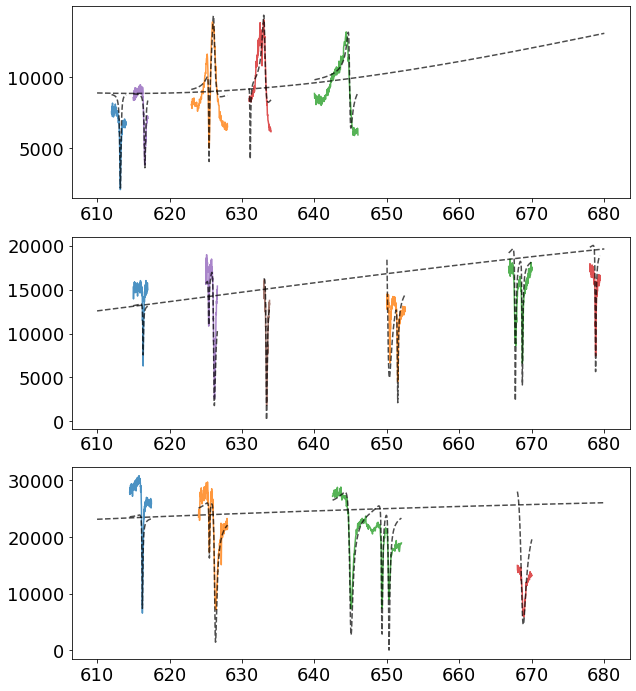

In [42]:
# Plot each scan and compare against fitted model
fig, ax = plt.subplots(nrows=3, figsize=[10, 12])

for detuning_idx, folder_idx in enumerate(folder_idx_list):
    siv_freqs_list, siv_data_list = collect_folder_data(folder_idx=folder_idx)
    
    for scan_idx, (freqs, data) in enumerate(zip(siv_freqs_list, siv_data_list)):
        print(detuning_idx, scan_idx, model_list_all[detuning_idx][scan_idx])
        ax[detuning_idx].plot(freqs, data, alpha=0.8)
        ax[detuning_idx].plot(freqs, get_val_from_model(out.params, scan_idx, detuning_idx, 
                                           model_list_all[detuning_idx][scan_idx], freqs),
                 c='k', ls='--', alpha=0.7)
    
    cavity_freqs = np.linspace(610, 680, 1000) 
    ax[detuning_idx].plot(cavity_freqs, cavity_ref(cavity_freqs, out.params[f"w_c_det{detuning_idx}"], out.params["k_in"], 
                           out.params["k_tot"], out.params["A"], out.params["B"]), 
             c='k', ls='--', alpha=0.7)

In [35]:
[(param, value.value) for param, value in out.params.items() if "w_c" in param]
# Supposed to be 610, 450, 530

[('w_c_det0', 615.1717585262744),
 ('w_c_det1', 549.9998636701657),
 ('w_c_det2', 430.00000071796967)]

## Force it to be the "correct" detunings

Fitting folder 406_610/
0 0 <function single_siv_ref at 0x000001A607BE1B80>
0 1 <function two_siv_ref at 0x000001A681D61670>
0 2 <function single_siv_ref at 0x000001A607BE1B80>
0 3 <function two_siv_ref at 0x000001A681D61670>
0 4 <function single_siv_ref at 0x000001A607BE1B80>
Fitting folder 406_450/
1 0 <function single_siv_ref at 0x000001A607BE1B80>
1 1 <function two_siv_ref at 0x000001A681D61670>
1 2 <function two_siv_ref at 0x000001A681D61670>
1 3 <function single_siv_ref at 0x000001A607BE1B80>
1 4 <function two_siv_ref at 0x000001A681D61670>
1 5 <function single_siv_ref at 0x000001A607BE1B80>
Fitting folder 406_530/
2 0 <function single_siv_ref at 0x000001A607BE1B80>
2 1 <function two_siv_ref at 0x000001A681D61670>
2 2 <function three_siv_ref at 0x000001A681D61700>
2 3 <function single_siv_ref at 0x000001A607BE1B80>


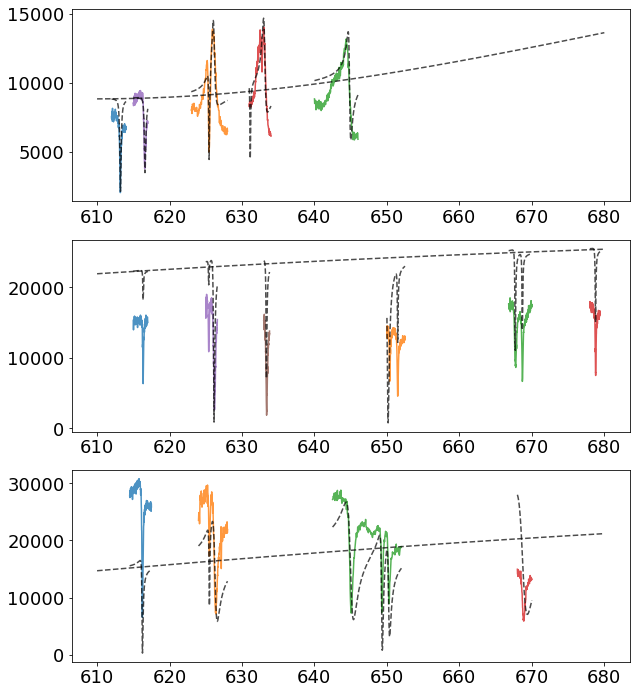

In [36]:
out_fixed = copy.deepcopy(out)
out_fixed.params["w_c_det0"].value = 610
out_fixed.params["w_c_det1"].value = 450
out_fixed.params["w_c_det2"].value = 530

fig, ax = plt.subplots(nrows=3, figsize=[10, 12])

for detuning_idx, folder_idx in enumerate(folder_idx_list):
    siv_freqs_list, siv_data_list = collect_folder_data(folder_idx=folder_idx)
    
    for scan_idx, (freqs, data) in enumerate(zip(siv_freqs_list, siv_data_list)):
        print(detuning_idx, scan_idx, model_list_all[detuning_idx][scan_idx])
        ax[detuning_idx].plot(freqs, data, alpha=0.8)
        ax[detuning_idx].plot(freqs, get_val_from_model(out_fixed.params, scan_idx, detuning_idx, 
                                           model_list_all[detuning_idx][scan_idx], freqs),
                 c='k', ls='--', alpha=0.7)
    
    cavity_freqs = np.linspace(610, 680, 1000) 
    ax[detuning_idx].plot(cavity_freqs, cavity_ref(cavity_freqs, out_fixed.params[f"w_c_det{detuning_idx}"], out.params["k_in"], 
                           out_fixed.params["k_tot"], out_fixed.params["A"], out_fixed.params["B"]), 
             c='k', ls='--', alpha=0.7)

# Force fixed cavity value 

In [37]:
fit_params = Parameters()
fit_params.add("w_c_det0", value=610, vary=False)
fit_params.add("w_c_det1", value=450, vary=False)
fit_params.add("w_c_det2", value=530, vary=False)
fit_params.add("k_in", value=50, min=10, max=150)
fit_params.add("k_tot", value=100, min=15, max=300)
fit_params.add("A", value=25000, min=5000, max=100000)
fit_params.add("B", value=0, vary=False)

model_list_all = []
w_up_guesses_all = []
folder_idx_list = []

model_list_all.append([single_siv_ref, two_siv_ref, single_siv_ref, two_siv_ref, single_siv_ref])
w_up_guesses_all.append([613, (625, 626), 644, (632, 633), 616.5])
folder_idx_list.append(4)

model_list_all.append([single_siv_ref, two_siv_ref, two_siv_ref, single_siv_ref, two_siv_ref, single_siv_ref])
w_up_guesses_all.append([616.4, (650.5, 651.5), (667.5, 668.5), 678.8, (625.5, 626.25), 633.4])
folder_idx_list.append(0)

model_list_all.append([single_siv_ref, two_siv_ref, three_siv_ref, single_siv_ref])
w_up_guesses_all.append([616.25, (625.5, 626.25), (645, 649.5, 650.25), 669])
folder_idx_list.append(2)

In [38]:
out = fit_combined_data(fit_params, objective, folder_idx_list, model_list_all, w_up_guesses_all)
lmfit.report_fit(out)

Fitting folder 406_610/
Fitting folder 406_450/
Fitting folder 406_530/
[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 15050
    # data points      = 2515
    # variables        = 49
    chi-square         = 3.9954e+10
    reduced chi-square = 16201993.9
    Akaike info crit   = 41799.1382
    Bayesian info crit = 42084.8096
[[Variables]]
    w_c_det0:               610 (fixed)
    w_c_det1:               450 (fixed)
    w_c_det2:               530 (fixed)
    k_in:                   31.1749409 +/- 1.17869835 (3.78%) (init = 50)
    k_tot:                  39.6002495 +/- 1.31762713 (3.33%) (init = 100)
    A:                      21856.0257 +/- 213.861070 (0.98%) (init = 25000)
    B:                      0 (fixed)
    w_up_scan0_det0:        613.181109 +/- 0.04025391 (0.01%) (init = 613)
    g_up_scan0_det0:        1.73604981 +/- 0.20566099 (11.85%) (init = 5.6)
    gamma_up_scan0_det0:    0.05 (fixed)
    g_up_1_scan1_det0:      1.00009380 +/- 0.0086105

Fitting folder 406_610/
0 0 <function single_siv_ref at 0x000001A607BE1B80>
0 1 <function two_siv_ref at 0x000001A681D61670>
0 2 <function single_siv_ref at 0x000001A607BE1B80>
0 3 <function two_siv_ref at 0x000001A681D61670>
0 4 <function single_siv_ref at 0x000001A607BE1B80>
Fitting folder 406_450/
1 0 <function single_siv_ref at 0x000001A607BE1B80>
1 1 <function two_siv_ref at 0x000001A681D61670>
1 2 <function two_siv_ref at 0x000001A681D61670>
1 3 <function single_siv_ref at 0x000001A607BE1B80>
1 4 <function two_siv_ref at 0x000001A681D61670>
1 5 <function single_siv_ref at 0x000001A607BE1B80>
Fitting folder 406_530/
2 0 <function single_siv_ref at 0x000001A607BE1B80>
2 1 <function two_siv_ref at 0x000001A681D61670>
2 2 <function three_siv_ref at 0x000001A681D61700>
2 3 <function single_siv_ref at 0x000001A607BE1B80>


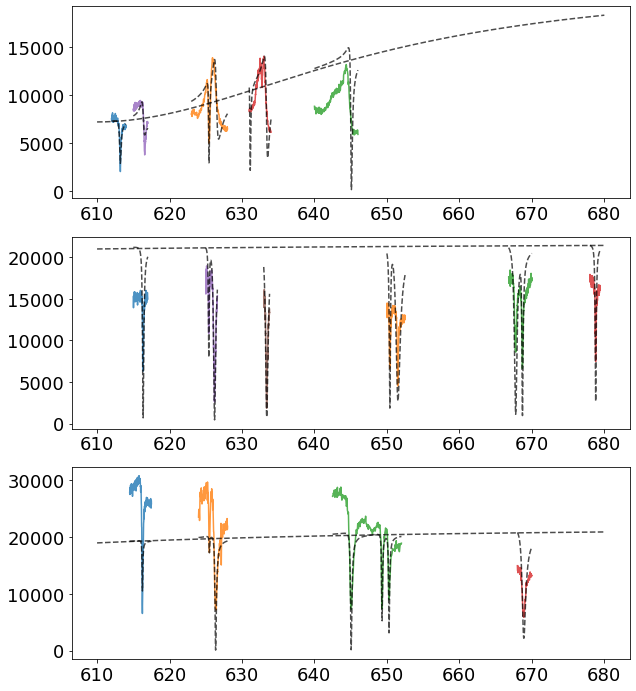

In [39]:
# Plot each scan and compare against fitted model
fig, ax = plt.subplots(nrows=3, figsize=[10, 12])

for detuning_idx, folder_idx in enumerate(folder_idx_list):
    siv_freqs_list, siv_data_list = collect_folder_data(folder_idx=folder_idx)
    
    for scan_idx, (freqs, data) in enumerate(zip(siv_freqs_list, siv_data_list)):
        print(detuning_idx, scan_idx, model_list_all[detuning_idx][scan_idx])
        ax[detuning_idx].plot(freqs, data, alpha=0.8)
        ax[detuning_idx].plot(freqs, get_val_from_model(out.params, scan_idx, detuning_idx, 
                                           model_list_all[detuning_idx][scan_idx], freqs),
                 c='k', ls='--', alpha=0.7)
    
    cavity_freqs = np.linspace(610, 680, 1000) 
    ax[detuning_idx].plot(cavity_freqs, cavity_ref(cavity_freqs, out.params[f"w_c_det{detuning_idx}"], out.params["k_in"], 
                           out.params["k_tot"], out.params["A"], out.params["B"]), 
             c='k', ls='--', alpha=0.7)

# Model power sinusoid

In [50]:
def objective_sin(params, freqs_lst_all, data_lst_all, model_list_all):
    residuals_lst = np.array([])
    
    for detuning_idx in range(len(freqs_lst_all)):
        
        freqs_lst = freqs_lst_all[detuning_idx]
        data_lst = data_lst_all[detuning_idx]
        model_list = model_list_all[detuning_idx]

        # compute residual per data set
        for scan_idx in range(len(data_lst)):
            model = model_list[scan_idx]
            freqs = freqs_lst[scan_idx]
            data = data_lst[scan_idx]
            
            sin_factor = params["A_sin"] * np.sin(freqs * params["w_sin"] + params["phi_sin"]) + 1

            residual = data - sin_factor * get_val_from_model(params, scan_idx, detuning_idx, model, freqs)
            residuals_lst = np.append(residuals_lst, residual)

    return residuals_lst

In [77]:
fit_params = Parameters()
fit_params.add("w_c_det0", value=610, vary=False)
fit_params.add("w_c_det1", value=450, vary=False)
fit_params.add("w_c_det2", value=530, vary=False)
fit_params.add("k_in", value=50, min=10, max=150)
fit_params.add("k_tot", value=100, min=15, max=300)
fit_params.add("A", value=25000, min=5000, max=100000)
fit_params.add("B", value=0, vary=False)

fit_params.add("A_sin", value=0.2, min=0, max=0.5)
fit_params.add("w_sin", value=1.0, min=0.1, max=5.0)
fit_params.add("phi_sin", value=3.14, min=0, max=6.28)

model_list_all = []
w_up_guesses_all = []
folder_idx_list = []

model_list_all.append([single_siv_ref, two_siv_ref, single_siv_ref, two_siv_ref, single_siv_ref])
w_up_guesses_all.append([613, (625, 626), 644, (632, 633), 616.5])
folder_idx_list.append(4)

model_list_all.append([single_siv_ref, two_siv_ref, two_siv_ref, single_siv_ref, two_siv_ref, single_siv_ref])
w_up_guesses_all.append([616.4, (650.5, 651.5), (667.5, 668.5), 678.8, (625.5, 626.25), 633.4])
folder_idx_list.append(0)

model_list_all.append([single_siv_ref, two_siv_ref, three_siv_ref, single_siv_ref])
w_up_guesses_all.append([616.25, (625.5, 626.25), (645, 649.5, 650.25), 669])
folder_idx_list.append(2)

In [78]:
out_sin = fit_combined_data(fit_params, objective_sin, folder_idx_list, model_list_all, w_up_guesses_all)
lmfit.report_fit(out_sin)

Fitting folder 406_610/
Fitting folder 406_450/
Fitting folder 406_530/
[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 15052
    # data points      = 2515
    # variables        = 52
    chi-square         = 3.9508e+10
    reduced chi-square = 16040798.4
    Akaike info crit   = 41776.9294
    Bayesian info crit = 42080.0909
##  Warning: uncertainties could not be estimated:
    w_up_scan2_det0:        at boundary
[[Variables]]
    w_c_det0:               610 (fixed)
    w_c_det1:               450 (fixed)
    w_c_det2:               530 (fixed)
    k_in:                   27.8068901 +/- 1.11706714 (4.02%) (init = 50)
    k_tot:                  35.6837629 +/- 1.31557836 (3.69%) (init = 100)
    A:                      20819.7358 +/- 252.389061 (1.21%) (init = 25000)
    B:                      0 (fixed)
    A_sin:                  0.10902429 +/-        nan (nan%) (init = 0.2)
    w_sin:                  0.11457036 +/-        nan (nan%) (init = 1)
    phi

C:\Users\Qi\AppData\Local\Programs\Python\Python38\lib\site-packages\lmfit\minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Qi\AppData\Local\Programs\Python\Python38\lib\site-packages\lmfit\minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


Fitting folder 406_610/
0 0 <function single_siv_ref at 0x000001A607BE1B80>
0 1 <function two_siv_ref at 0x000001A681D61670>
0 2 <function single_siv_ref at 0x000001A607BE1B80>
0 3 <function two_siv_ref at 0x000001A681D61670>
0 4 <function single_siv_ref at 0x000001A607BE1B80>
Fitting folder 406_450/
1 0 <function single_siv_ref at 0x000001A607BE1B80>
1 1 <function two_siv_ref at 0x000001A681D61670>
1 2 <function two_siv_ref at 0x000001A681D61670>
1 3 <function single_siv_ref at 0x000001A607BE1B80>
1 4 <function two_siv_ref at 0x000001A681D61670>
1 5 <function single_siv_ref at 0x000001A607BE1B80>
Fitting folder 406_530/
2 0 <function single_siv_ref at 0x000001A607BE1B80>
2 1 <function two_siv_ref at 0x000001A681D61670>
2 2 <function three_siv_ref at 0x000001A681D61700>
2 3 <function single_siv_ref at 0x000001A607BE1B80>


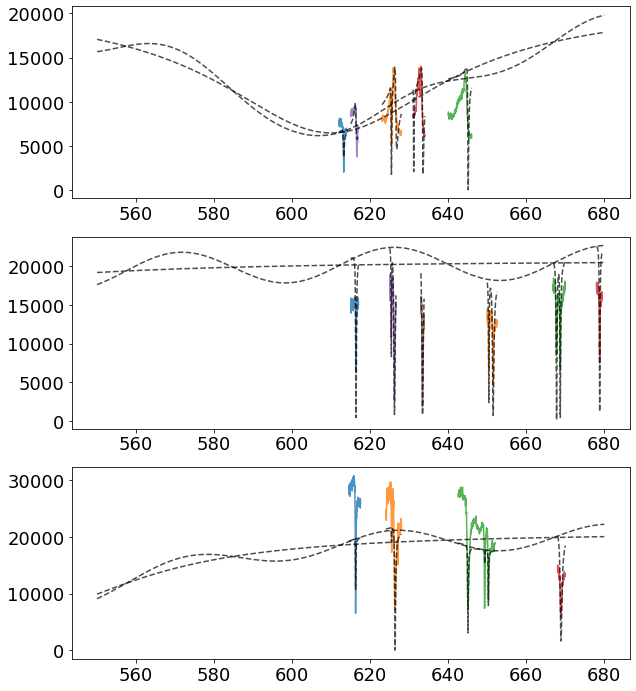

In [79]:
# Plot each scan and compare against fitted model
fig, ax = plt.subplots(nrows=3, figsize=[10, 12])

for detuning_idx, folder_idx in enumerate(folder_idx_list):
    siv_freqs_list, siv_data_list = collect_folder_data(folder_idx=folder_idx)
    
    for scan_idx, (freqs, data) in enumerate(zip(siv_freqs_list, siv_data_list)):
        print(detuning_idx, scan_idx, model_list_all[detuning_idx][scan_idx])
        ax[detuning_idx].plot(freqs, data, alpha=0.8)
        
        sin_factor = out_sin.params["A_sin"] * np.sin(freqs * out_sin.params["w_sin"] + out_sin.params["phi_sin"]) + 1
        
        ax[detuning_idx].plot(freqs, sin_factor * get_val_from_model(out_sin.params, scan_idx, detuning_idx, 
                                           model_list_all[detuning_idx][scan_idx], freqs),
                 c='k', ls='--', alpha=0.7)
    
    cavity_freqs = np.linspace(550, 680, 1000) 
    sin_factor = out_sin.params["A_sin"] * np.sin(cavity_freqs * out_sin.params["w_sin"] + out_sin.params["phi_sin"]) + 1

    ax[detuning_idx].plot(cavity_freqs, cavity_ref(cavity_freqs, out_sin.params[f"w_c_det{detuning_idx}"], out_sin.params["k_in"], 
                           out_sin.params["k_tot"], out_sin.params["A"], out_sin.params["B"]), 
             c='k', ls='--', alpha=0.7)
    ax[detuning_idx].plot(cavity_freqs, sin_factor * cavity_ref(cavity_freqs, out_sin.params[f"w_c_det{detuning_idx}"], out_sin.params["k_in"], 
                           out_sin.params["k_tot"], out_sin.params["A"], out_sin.params["B"]), 
             c='k', ls='--', alpha=0.7)